### A simple notebook to test and evaluate the image quality from the images generated by the DCGAN 

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [33]:
# Iteration number to test with
ITERATION=9999

# Attack to test with
ATTACK="FGSM"

# Original batch size
BATCH=64

In [24]:
# Device to use in this notebook
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

In [25]:
# Various hyperparameters
nc = 3
nz = 100
ngf = 64
ndf = 64

In [26]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [34]:
checkpoint_path = f"../DCGAN/FGSM/Models/Checkpoint-{ATTACK}-Epoch-{ITERATION}-{BATCH}.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

/tmp/ipykernel_1901021/2972943549.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [35]:
netG = Generator(1).to(device)  # Replace with actual Generator class
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.eval()  # Set to evaluation mode

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [36]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root=f"../Attacks/{ATTACK}", transform=transform)

class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(path)  # Extract filename
        class_name = self.classes[target]  # Get class label from index
        return image, filename, class_name

In [37]:
TESTING_BATCH_SIZE=64
dataloader = DataLoader(CustomDataset(root=f"../Attacks/{ATTACK}", transform=transform), batch_size=TESTING_BATCH_SIZE, shuffle=True)

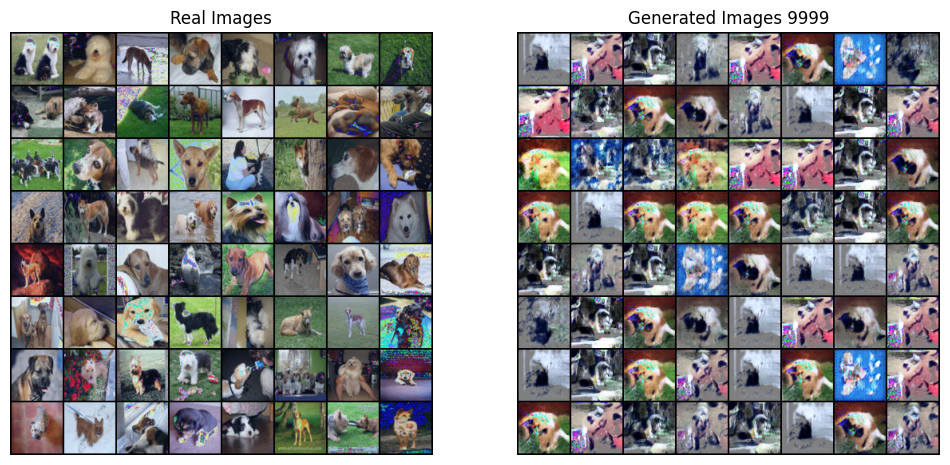

In [38]:
# Generate fake images and display them alongside real images
with torch.no_grad():  # No gradients needed
    for i, (real_images, filenames, class_names) in enumerate(dataloader):
        real_images = real_images.to(device)  # Move real images to device

        # Generate random noise on the correct device
        noise = torch.randn(TESTING_BATCH_SIZE, nz, 1, 1, device=device)

        # Generate fake images
        fake_images = netG(noise).to("cpu")  # Move generated images to CPU for visualization

        # Create grids for real and fake images
        real_grid = vutils.make_grid(real_images.to("cpu"), normalize=True, padding=2)
        fake_grid = vutils.make_grid(fake_images, normalize=True, padding=2)

        # Plot both grids side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

        # Show real images
        axes[0].imshow(real_grid.permute(1, 2, 0))  # Convert to HWC format for Matplotlib
        axes[0].axis("off")
        axes[0].set_title("Real Images")

        # Show fake images
        axes[1].imshow(fake_grid.permute(1, 2, 0))
        axes[1].axis("off")
        axes[1].set_title(f"Generated Images {ITERATION}")

        fig.savefig(f"Comparison-{ITERATION}", bbox_inches="tight", dpi=300)  # High-quality save

        plt.show()
        break  # Show only one batch

In [32]:
output_dir = f"Generated-Images-{ITERATION}"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, (real_img, filename, class_name) in enumerate(dataloader):
        real_img = real_img.to(device)

        # Generate a random noise vector
        noise = torch.randn(1, nz, 1, 1, device=device)

        # Generate the fake image
        fake_img = netG(noise).detach().cpu()

        # Convert to PIL image
        fake_pil = transforms.ToPILImage()(fake_img.squeeze(0))

        # Create subfolder for class if it doesn't exist
        class_dir = os.path.join(output_dir, class_name[0])
        os.makedirs(class_dir, exist_ok=True)

        # Save with the original filename
        save_path = os.path.join(class_dir, filename[0])  # filename is a list, get the first element
        fake_pil.save(save_path)

print("Images saved!")

Images saved!
